In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time

from YOLO_API import YoloV3_API

In [2]:
img_dir = "../data/image/"
anno_dir = "../data/annotation/"

In [3]:
yoloAPI = YoloV3_API(
    img_dir=img_dir,
    annotation_dir=anno_dir,
    saved_model_name='yolo_model.h5',
    train_size=0.8,
    height=416,
    width=416,
    threshold=0.5,
    batch_size=2)

Image directory: ../data/image/
Annotation directory: ../data/annotation/
Saved model name: yolo_model.h5
Train/validation size ratio: 0.8
Training size: 416x416
Threshold: 0.5
Batch Size: 2

All Image and annotation size: 387
Unique labels: dict_keys(['car', 'bus'])
Generated Anchor Boxes: [9, 8, 18, 15, 30, 25, 43, 66, 45, 31, 60, 41, 80, 114, 83, 50, 94, 77]

Training image and annotation size: 309
Validation image and annotation size: 78
Maximum bounding boxes in all images: 7

Train Generator created: To access, use <YoloV3_API.train_generator>
Validation Generator created: To access, use <YoloV3_API.valid_generator>

YOLOv3 Training Model created: To access, use <YoloV3_API.train_model>

YOLOv3 Inference Model created: To access, use <YoloV3_API.infer_model>

Train Model Summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_

In [ ]:
%%time
history = yoloAPI.fit_generator(epoch=300, lr=1e-4)

In [4]:
#### Proto
inf_model = yoloAPI.infer_model
inf_model.load_weights('best_yolo_model.h5')

In [5]:
### Read and resize image # Preprocess image
import glob
import os

testimgpath = '..\data\Test_images'
file_types = ('\*.jpg', '\*.jpeg')
test_images = []
for files in file_types:
    test_images.extend(glob.glob(testimgpath+files))

expected_height, expected_width = 416, 416
    
img = cv2.imread(test_images[0])
img_resized = cv2.resize(img[:,:,::-1]/255, (expected_width, expected_height))
input_img = np.expand_dims(img_resized, 0) # Shape is now (1, 416, 416, 3)
input_img.shape

(1, 416, 416, 3)

In [6]:
# Actual prediction
pred = inf_model.predict(input_img)
print(f'Big Pred: {pred[0].shape}')
print(f'Mid Pred: {pred[1].shape}')
print(f'Small Pred: {pred[2].shape}')

Big Pred: (1, 13, 13, 21)
Mid Pred: (1, 26, 26, 21)
Small Pred: (1, 52, 52, 21)


In [7]:
from scipy.special import expit #sigmoid
from imgaug import BoundingBox, BoundingBoxesOnImage
import imgaug as ia

In [9]:
# Calculate Bounding Boxes for each predictions
all_boxes = []
for prediction in range(len(pred)):
    currPred = pred[prediction]
    anchors = yoloAPI.anchor_boxes[(2 - prediction) * 6 : (3 - prediction) * 6]
    
    grid_height, grid_width = currPred.shape[:2]
    pred_boxes = 3
    pred_out = currPred.reshape((grid_height, grid_width, pred_boxes, -1))
    num_cls = currPred.shape[-1] - 5
    
    boxes = []
    currPred[...,:2]=expit(currPred[...,:2])
    currPred[...,4]=expit(currPred[...,4])
    currPred[...,5:]=currPred[...,4][..., np.newaxis] * expit(currPred[...,5:])
    currPred[...,5:]=currPred[...,5:] > 0.5
    
    for idx in range(grid_height*grid_width): # Traverse entire grid
        r = idx//grid_width
        c = idx%grid_width
        for box_idx in range(pred_boxes):
            objectiveness_score=currPred[r, c, box_idx, 4] # Objectiveness score @ 5th index
            if (objectiveness_score <= 0.5):
                continue
            x, y, w, h = currPred[r, c, box_idx, :4]
            x = (c + x) / grid_width
            y = (r + y) / grid_height                                
            w = yoloAPI.anchor_boxes[2 * box_idx + 0] * np.exp(w) / expected_width
            h = yoloAPI.anchor_boxes[2 * box_idx + 1] * np.exp(h) / expected_height
            classes = currPred[r, c, box_idx, 5:]
            box = BoundingBox(
                x1=x-w/2,
                x2=y-h/2,
                y1=x+w/2,
                y2=y+h/2,
                label=classes)
            print(box)
            boxes.append(box)
    all_boxes += boxes
iabox = BoundingBoxesOnImage(all_boxes, shape=(416, 416))

BoundingBox(x1=0.0371, y1=0.0587, x2=0.6128, y2=0.6321, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.0262, y1=0.0695, x2=0.6044, y2=0.6405, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.0118, y1=0.0839, x2=0.5924, y2=0.6525, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1140, y1=0.1356, x2=0.6128, y2=0.6321, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1032, y1=0.1464, x2=0.6044, y2=0.6405, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.0887, y1=0.1609, x2=0.5924, y2=0.6525, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1909, y1=0.2125, x2=0.6128, y2=0.6321, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1801, y1=0.2234, x2=0.6044, y2=0.6405, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1657, y1=0.2378, x2=0.5924, y2=0.6525, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [48]:
count = 0
for b in iabox.bounding_boxes:
    print(count)
    print(b)
    count += 1

In [50]:
iabox.bounding_boxes

[]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


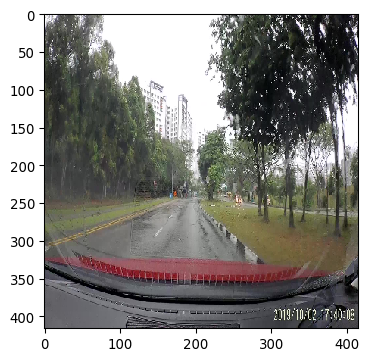

In [89]:
iabox1 = BoundingBoxesOnImage(test, shape=(416, 416))
ia.imshow(iabox1.draw_on_image(input_img[0]))